In [146]:
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../src/')
import densities, conditionals

# Kalman filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
z_{t} = A z_{t-1} + b + \zeta_t \\
x_{t} = C z_t + d + \xi_t,
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\zeta_t \sim N(0,Q_z)\\
\xi_t \sim N(0,Q_x).
$$

In [170]:
class KalmanFilter:
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        """ This is a linear Kalman filter.
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditionals.ConditionalGaussianDensity(numpy.array([A]), numpy.array([b]), numpy.array([Qz]))
        self.emission_density = conditionals.ConditionalGaussianDensity(numpy.array([C]), numpy.array([d]), numpy.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self):
        Sigma = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        mu = numpy.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * numpy.log(numpy.ones(self.T+1))
        return densities.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        """ Forward iteration.
        """
        for t in range(1, self.T):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_1:t-1) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice([t-1])
        # p(z_t|x_{1:t-1})
        cur_prediction_density = pre_filter_density.affine_marginal_transformation(self.state_density)
        # Write result into prediction density collection
        self.prediction_density.update([t], cur_prediction_density)
        
        
    def filtering(self, t: int):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice([t])
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = cur_prediction_density.affine_conditional_transformation(self.emission_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t:t+1])
        # Write result into filter density collection
        self.filter_density.update([t], cur_filter_density)
        
class KalmanSmoother(KalmanFilter):
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        super().__init__(X, A, b, Qz, C, d, Qx)
        self.smoothing_density = self._setup_density()
        
    def backward_path(self):
        """ Backward iteration.
        """
        last_filter_density = self.filter_density.slice([self.T])
        self.smoothing_density.update([self.T], last_filter_density)
        
        for t in numpy.arange(self.T-1,-1,-1):
            self.smoothing(t)
        
    def smoothing(self, t: int):
        """
        """
        # p(z_{t} | x_{1:t}) 
        cur_filter_density = self.prediction_density.slice([t])
        # p(z_{t} | z_{t+1}, x_{1:t}) 
        backward_density = cur_filter_density.affine_conditional_transformation(self.state_density)
        # p(z_{t+1} | x_{1:T})
        post_smoothing_density = self.smoothing_density.slice([t+1])
        # p(z_{t} | x_{1:T})
        cur_smoothing_density = post_smoothing_density.affine_marginal_transformation(backward_density)
        # Write result into smoothing density collection
        self.smoothing_density.update([t], cur_smoothing_density)
        

In [171]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .1
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)
Qx = noise_x ** 2 * numpy.eye(Dx)
Qz = noise_z ** 2 * numpy.eye(Dz)
A, b = numpy.eye(Dz), numpy.zeros((Dz,))
C, d = numpy.eye(Dx), numpy.zeros((Dx,))

ks = KalmanSmoother(X, A, b, Qz, C, d, Qx)

In [172]:
ks.forward_path()
ks.backward_path()

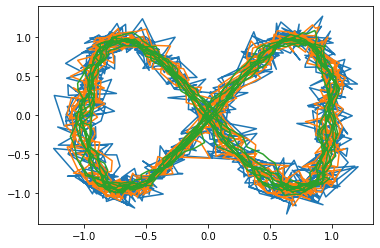

In [173]:
pyplot.plot(X[:,0], X[:,1])
pyplot.plot(ks.filter_density.mu[:,0], ks.filter_density.mu[:,1])
pyplot.plot(ks.smoothing_density.mu[:,0], ks.smoothing_density.mu[:,1])

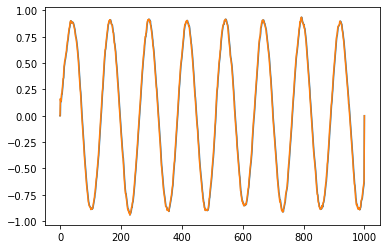

In [174]:
pyplot.plot(kf.prediction_density.mu[:,0])
pyplot.plot(kf.filter_density.mu[:,0])

In [291]:
class StateSpace_EM:
    
    def __init__(self, X: numpy.ndarray, Dz: int, noise_x: float=.1, noise_z: float=.1):
        self.T, self.Dx = X.shape
        self.Dz = Dz
        self.Qx = noise_x ** 2 * numpy.eye(self.Dx)
        self.Qx_inv = numpy.linalg.inv(self.Qx)
        self.Qz = noise_z ** 2 * numpy.eye(self.Dz)
        self.Qz_inv = numpy.linalg.inv(self.Qz)
        self.A, self.b = numpy.eye(Dz), numpy.zeros((Dz,))
        self.C, self.d = numpy.random.randn(self.Dx, self.Dz), numpy.zeros((Dx,))
        self.ks = KalmanSmoother(X, self.A, self.b, self.Qz, self.C, self.d, self.Qx)
        
    def estep(self):
        self.ks.forward_path()
        self.ks.backward_path()
        
    def get_marginal_likelihood(self):
        return numpy.sum(self.ks.filter_density.lnZ)
        
    def calculate_Q(self):
        # E[(z_t - Az_{t-1} - b)'Qz^{1}(z_{t} - Az_{t-1} - b)]
        joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
        A = numpy.hstack([-self.A, numpy.eye(self.Dz)])
        a = -self.b
        B = numpy.dot(self.Qz_inv, A)
        b = -numpy.dot(self.Qz_inv, ssm.b)
        Ezz =  numpy.sum(joint_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b)[:-1])
        Ezz += self.T * (self.ks.state_density.ln_det_Sigma[0] + self.Dz * numpy.log(2 * numpy.pi))
        # E[(x_t - Cz_{t} - d)'Qx^{1}(x_{t} - Cz_{t} - d)]
        A = -self.C
        a_t = ks.X - self.d[None]
        B = numpy.dot(self.Qx_inv, A)
        b_t = numpy.dot(self.Qz_inv, a_t.T).T
        Exx = 0
        for t in range(1,self.T+1):
            cur_smooth_density = self.ks.smoothing_density.slice([t])
            Exx += cur_smooth_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a_t[t-1], B_mat=B, b_vec=b_t[t-1])[0]
        Exx += self.T * (self.ks.emission_density.ln_det_Sigma[0] + self.Dx * numpy.log(2 * numpy.pi))
        # E[(z_0 - mu0)'Sigma0^{1}(z_0 - mu0)]
        init_smooth_density = self.ks.smoothing_density.slice([0])
        A = numpy.eye(self.Dz)
        a = self.ks.filter_density.mu[0]
        B = self.ks.filter_density.Lambda[0]
        b = numpy.dot(self.ks.filter_density.Lambda[0], a)
        Ez0 = init_smooth_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b)[0]
        Ez0 += self.ks.filter_density.ln_det_Sigma[0] + self.Dz * numpy.log(2 * numpy.pi)
        return - .5 * (Exx + Ezz + Ez0)

In [292]:
ssm = StateSpace_EM(X, Dz,)
ssm.estep()

In [293]:
ssm.get_marginal_likelihood()

83672.68233981173

In [294]:
ssm.calculate_Q()

2599.4600592151005

In [264]:
joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
ssm.Qz_inv.shape 

(2, 2)

In [226]:
A = numpy.hstack([-ssm.A, numpy.eye(ssm.Dz)])
a = -ssm.b
B = numpy.dot(ssm.Qz_inv, A)
b = -numpy.dot(ssm.Qz_inv, ssm.b)
- .5 * numpy.sum(joint_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b))

-1001.0000000000002

In [211]:
B.shape

(2, 4)